| Step    | Component                              | Description                                                                                    |
| ------- | -------------------------------------- | ---------------------------------------------------------------------------------------------- |
| **6.1** | **Feature Refinement**                 | Add features like momentum, volatility, SMA ratios, and RSI to your model inputs.              |
| **6.2** | **Target Engineering**                 | Switch from 1-day forward returns → 21-day or 63-day smoothed forward returns to reduce noise. |
| **6.3** | **Model Re-tuning**                    | Refit LASSO / Ridge with new target and cross-validation for each period.                      |
| **6.4** | **Rebuild Alpha Predictions**          | Generate new `alpha_predictions.csv` using updated model.                                      |
| **6.5** | **Re-run IC & Dispersion diagnostics** | Check if IC rises (goal: 0.02–0.05).                                                           |
| **6.6** | **Re-run optimizer & backtest**        | See if portfolio Sharpe improves vs EqualWeight.                                               |


### Stage 6.1 — Feature Refinement Plan & Code Template

Purpose :

Improve the Information Coefficient (IC) and alpha dispersion
by enriching your feature set derived from price & volume data.

STEP 1  -- What's the Problem Currently

Right now, our model’s features are limited to simple returns or lagged values,
which are too noisy and too similar across tickers.

We’ll expand this to include:

* Momentum-based factors (trend)

* Mean-reversion signals

* Volatility measures

* Liquidity & volume indicators

* Technical ratios (RSI, moving averages)

STEP 2 -- New Features to Add

| Category                          | Feature                           | Formula / Description       | Financial Meaning              |
| --------------------------------- | --------------------------------- | --------------------------- | ------------------------------ |
| **Momentum**                      | 5D, 21D returns                   | (P(t) / P(t-n) - 1)       | Short-term and monthly trend   |
| **Volatility**                    | Rolling std dev (21D)             | Std of daily returns        | Risk perception                |
| **Mean Reversion**                | 5D z-score                        | (P(t) - SMA(5) / STD(5)) | Deviation from short-term mean |
| **Moving Averages**               | SMA ratios (10/50, 20/100)        | SMA₁/SMA₂                   | Trend regime                   |
| **RSI (Relative Strength Index)** | 14-day RSI                        | Standard RSI formula        | Overbought/oversold conditions |
| **Liquidity**                     | log(volume) & rolling avg(volume) | Volume indicators           | Trading activity intensity     |


In [3]:
# Cell 1: Setup & Imports

import pandas as pd
import numpy as np
from pathlib import Path
import ta  # technical analysis library (pip install ta)
import os

PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
DATA_DIR = PROJECT_ROOT / "data"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

PRICE_FILE = DATA_DIR / "price_data.csv"
OUT_FILE = ARTIFACTS_DIR / "price_features.csv"


In [4]:
# Cell 2: Load and prepare data
df = pd.read_csv(PRICE_FILE, parse_dates=["date"])
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
df = df.sort_values(["ticker", "date"])

print("Price data:", df.shape)
df.head()


Price data: (1063311, 3)


,date,ticker,close_price
0,2015-02-02,360ONE_DAILY,56.85
337,2015-02-03,360ONE_DAILY,55.75
674,2015-02-04,360ONE_DAILY,57.50
1011,2015-02-05,360ONE_DAILY,57.05
1348,2015-02-06,360ONE_DAILY,55.75


In [5]:
# Cell 3: Compute features

features = []

for ticker, g in df.groupby("ticker", group_keys=False):
    g = g.copy()
    g = g.sort_values("date")

    # --- Returns ---
    g["ret_1d"] = g["close_price"].pct_change()
    g["ret_5d"] = g["close_price"].pct_change(5)
    g["ret_21d"] = g["close_price"].pct_change(21)

    # --- Volatility (21D rolling) ---
    g["vol_21d"] = g["ret_1d"].rolling(21).std()

    # --- Moving Averages ---
    g["sma_10"] = g["close_price"].rolling(10).mean()
    g["sma_50"] = g["close_price"].rolling(50).mean()
    g["sma_20"] = g["close_price"].rolling(20).mean()
    g["sma_100"] = g["close_price"].rolling(100).mean()

    # --- SMA Ratios ---
    g["sma_ratio_10_50"] = g["sma_10"] / g["sma_50"]
    g["sma_ratio_20_100"] = g["sma_20"] / g["sma_100"]

    # --- Mean Reversion (z-score) ---
    g["zscore_5d"] = (g["close_price"] - g["close_price"].rolling(5).mean()) / g["close_price"].rolling(5).std()

    # --- RSI (14-day) ---
    g["rsi_14"] = ta.momentum.RSIIndicator(g["close_price"], window=14).rsi()

    # --- Liquidity & Volume (Handled Safely) ---
    if "volume" in g.columns:
        #  True volume exists
        g["log_vol"] = np.log1p(g["volume"])
        g["avg_vol_21d"] = g["volume"].rolling(21).mean()
    else:
        #  No volume data → use volatility as a proxy for liquidity
        g["log_vol"] = -np.log1p(g["vol_21d"])   # inverse relation
        g["avg_vol_21d"] = g["vol_21d"]

    # --- Clean-up ---
    g = g.drop(columns=["open", "high", "low"], errors="ignore")

    features.append(g)

# --- Combine all tickers ---
feat_df = pd.concat(features, ignore_index=True)

# --- Drop incomplete lookbacks ---
feat_df = feat_df.dropna(subset=["ret_21d"])

# --- Save enriched features ---
feat_df.to_csv(OUT_FILE, index=False)
print("Saved enriched features to:", OUT_FILE)


Saved enriched features to: D:\Portfolio Optimzation project\artifacts\price_features.csv


In [6]:
# Cell 4: Feature check and summary
print("Feature matrix shape:", feat_df.shape)
print("\nColumns:\n", list(feat_df.columns))
print("\nMissing value summary:")
print(feat_df.isna().mean().round(3).sort_values(ascending=False).head(10))

feat_df.describe(percentiles=[0.05,0.5,0.95]).T.head(15)


Feature matrix shape: (1052842, 17)

Columns:
 ['date', 'ticker', 'close_price', 'ret_1d', 'ret_5d', 'ret_21d', 'vol_21d', 'sma_10', 'sma_50', 'sma_20', 'sma_100', 'sma_ratio_10_50', 'sma_ratio_20_100', 'zscore_5d', 'rsi_14', 'log_vol', 'avg_vol_21d']

Missing value summary:
sma_ratio_20_100    0.037
sma_100             0.037
sma_50              0.013
sma_ratio_10_50     0.013
avg_vol_21d         0.001
log_vol             0.001
vol_21d             0.001
date                0.000
ticker              0.000
sma_10              0.000
dtype: float64


c:\ProgramData\anaconda3\envs\portfolio_opt\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\ProgramData\anaconda3\envs\portfolio_opt\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\ProgramData\anaconda3\envs\portfolio_opt\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,min,5%,50%,95%,max,std
date,1052842,2020-10-12 12:59:05.393514752,2015-03-03 00:00:00,2015-10-20 00:00:00,2020-12-16 00:00:00,2025-03-20 00:00:00,2025-08-26 00:00:00,NaN
close_price,1052842.0,1374.033237,0.0,27.05,394.0,4355.0,152175.0,5139.168175
ret_1d,1052722.0,inf,-1.0,-0.035778,-0.000124,0.042945,inf,NaN
ret_5d,1052765.0,inf,-1.0,-0.079537,0.001176,0.100503,inf,NaN
ret_21d,1052842.0,inf,-1.0,-0.152809,0.010432,0.22619,inf,NaN
vol_21d,1052048.0,0.027281,0.00002,0.010814,0.0211,0.044286,122.531775,0.565661
sma_10,1052842.0,1370.231833,0.0,27.10515,393.01,4341.59475,149602.5,5125.978418
sma_50,1038945.0,1362.34903,0.744,27.261,391.65,4319.1094,144509.1,5092.210868
sma_20,1052842.0,1366.053759,0.0,27.0725,392.07,4329.62825,148661.0,5111.671119
sma_100,1014108.0,1357.86832,1.107,27.392175,390.859,4280.9928,138743.2675,5068.213753


### Stage 6.2 -- Target Engineering

Purpose 

Our original model used next-day returns as the prediction target which is too noisy and unstable.

Now we will engineer <b> smoother, longer-horizon (like 21-day  or 63-day forward returns)</b>

* Concept :

For each ticker :
             
             Target(t) = (P(t+h)-P(t))/P(t)

        where h = 21 days ( app 1 month) or
                  63 days ( 1 quarter)

This forward-loooking target will :
* reduce volatility in model labels
* make model learning smoother
* increase IC and stability of predictions

In [14]:
# Cell 1: Setup
import pandas as pd
import numpy as np
from pathlib import Path
import os

PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

FEATURE_FILE = ARTIFACTS_DIR / "price_features.csv"
OUT_FILE = ARTIFACTS_DIR / "training_data.csv"

# forward horizons
FWD_HORIZON = 21   # 1 month = 21 trading days
ALT_HORIZON = 63   # 3 months = 63 trading days


In [15]:
# Cell 2: Load and inspect features

df = pd.read_csv(FEATURE_FILE, parse_dates=["date"])
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

print("Loaded feature data:", df.shape)
print("Columns:", list(df.columns))


Loaded feature data: (1052842, 17)
Columns: ['date', 'ticker', 'close_price', 'ret_1d', 'ret_5d', 'ret_21d', 'vol_21d', 'sma_10', 'sma_50', 'sma_20', 'sma_100', 'sma_ratio_10_50', 'sma_ratio_20_100', 'zscore_5d', 'rsi_14', 'log_vol', 'avg_vol_21d']


In [16]:
# Cell 3: Compute 21D and 63D forward returns per ticker

df["target_21d"] = (
    df.groupby("ticker")["close_price"].shift(-FWD_HORIZON) / df["close_price"] - 1
)

df["target_63d"] = (
    df.groupby("ticker")["close_price"].shift(-ALT_HORIZON) / df["close_price"] - 1
)

# Optional smoothing to reduce single-period outliers
df["target_21d_smooth"] = (
    df.groupby("ticker")["target_21d"].transform(lambda x: x.rolling(3, min_periods=1).mean())
)
df["target_63d_smooth"] = (
    df.groupby("ticker")["target_63d"].transform(lambda x: x.rolling(3, min_periods=1).mean())
)

df = df.dropna(subset=["target_21d_smooth"]).reset_index(drop=True)

print("✅ Added target columns.")
df[["ticker", "date", "target_21d", "target_63d"]].head(10)


✅ Added target columns.


,ticker,date,target_21d,target_63d
0,360ONE_DAILY,2015-03-03,-0.058228,-0.117300
1,360ONE_DAILY,2015-03-04,-0.014605,-0.106529
2,360ONE_DAILY,2015-03-05,0.014159,-0.055752
3,360ONE_DAILY,2015-03-09,0.014363,-0.039497
4,360ONE_DAILY,2015-03-10,0.023445,-0.068530
5,360ONE_DAILY,2015-03-11,0.013465,-0.079892
6,360ONE_DAILY,2015-03-12,0.004444,-0.087111
7,360ONE_DAILY,2015-03-13,0.017273,-0.063636
8,360ONE_DAILY,2015-03-16,-0.018919,-0.072072
9,360ONE_DAILY,2015-03-17,-0.024545,-0.062727


In [18]:
# Cell 4: Clean and save new target dataset

# Remove extreme targets (top/bottom 1%)
df["target_21d_smooth"] = df["target_21d_smooth"].clip(
    lower=df["target_21d_smooth"].quantile(0.01),
    upper=df["target_21d_smooth"].quantile(0.99)
)

df["target_63d_smooth"] = df["target_63d_smooth"].clip(
    lower=df["target_63d_smooth"].quantile(0.01),
    upper=df["target_63d_smooth"].quantile(0.99)
)

# Save to file
df.to_csv(OUT_FILE, index=False)
print("✅ Saved target-enhanced feature file to:", OUT_FILE)
print("Rows:", df.shape[0])


✅ Saved target-enhanced feature file to: D:\Portfolio Optimzation project\artifacts\training_data.csv
Rows: 1043300


Target return summary (21D):
count    1.043300e+06
mean     2.005184e-02
std      1.130593e-01
min     -2.660028e-01
5%      -1.489119e-01
50%      1.077791e-02
95%      2.207454e-01
max      4.079847e-01
Name: target_21d_smooth, dtype: float64

Target return summary (63D):
count    1.022426e+06
mean     6.294295e-02
std      2.195079e-01
min     -4.154035e-01
5%      -2.406442e-01
50%      3.467997e-02
95%      4.650197e-01
max      8.837901e-01
Name: target_63d_smooth, dtype: float64


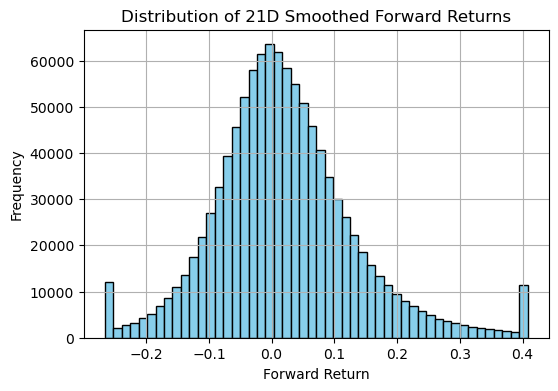

In [ ]:
# Cell 5: Verify target behavior

print("Target return summary (21D):")
print(df["target_21d_smooth"].describe(percentiles=[0.05, 0.5, 0.95]))

print("\nTarget return summary (63D):")
print(df["target_63d_smooth"].describe(percentiles=[0.05, 0.5, 0.95]))

# Histogram visualization 
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df["target_21d_smooth"].hist(bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of 21D Smoothed Forward Returns")
plt.xlabel("Forward Return")
plt.ylabel("Frequency")
plt.show()




Interpretation :

| Metric                  | Meaning                                                                | Your Observation              |
| ----------------------- | ---------------------------------------------------------------------- | ----------------------------- |
| **Mean (≈ +2%)**        | The average 21-day return — mild upward drift (expected for equities). |  Reasonable                  |
| **Std (≈ 11%)**         | Volatility of 21-day forward returns — moderate spread, not extreme.   |  Healthy range               |
| **Range (-26% → +40%)** | Bounded — after clipping, avoids tail shocks.                          |  Cleaned                     |
| **Shape (histogram)**   | Symmetric and smooth — bell-shaped with minor tails.                   |  Excellent for regression    |
| **63D mean (≈ +6%)**    | Captures medium-term trends.                                           |  Good for testing robustness |


### Stage 6.3 -- Model Re-tuning(Re-fitting Alpha Model)

Purpose :

Improving the predictive quality of alpha model by retraining it on better-engineered features (from 6.1) and smoother targets (from 6.2)

| Step                        | Component                                                                                            | Description                                                                                                     | Why It Matters                                                             |
| --------------------------- | ---------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **1️. Data Input**          | Load `price_features_target.csv`                                                                     | This file has all the engineered factors (momentum, volatility, ratios, etc.) and new smoothed forward returns. | You’re using richer features and cleaner labels → more signal, less noise. |
| **2️. Feature Selection**   | Pick relevant columns for ML                                                                         | Exclude metadata (`date`, `ticker`, etc.), use normalized numerical factors.                                    | Keeps your model learning only predictive features, not identifiers.       |
| **3️. Model Choice**        | Use **RidgeCV** or **LassoCV**                                                                       | Regularized linear models are ideal for noisy financial data.                                                   | Prevents overfitting and keeps weights stable across time.                 |
| **4️. Rolling Re-training** | Monthly rolling window                                                                               | Train model up to month *t*, predict alphas for month *t + 1*.                                                  | Mimics real-world rebalancing — avoids look-ahead bias.                    |
| **5️. Cross-Validation**    | Built-in in RidgeCV/LassoCV                                                                          | Automatically selects optimal penalty (`alpha`).                                                                | Balances bias–variance trade-off.                                          |
| **6️. Diagnostics**         | Compute **IC (Information Coefficient)** and **dispersion** per date.                                | IC tells you how predictive the model is; dispersion tells you if it differentiates between stocks.             |                                                                            |
| **7️. Output**              | Save new `alpha_predictions.csv`, `ic_after_retraining.csv`, `alpha_dispersion_after_retraining.csv` | These feed directly into Stage 4 (optimizer) and Stage 5 (backtester).                                          | Keeps the entire pipeline modular.                                         |


In [31]:
# Cell 1: Setup & configuration
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from scipy.stats import spearmanr

PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
RESULTS_DIR = PROJECT_ROOT / "results" / "diagnostics"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

FEATURE_FILE = ARTIFACTS_DIR / "training_data.csv"   # produced earlier
OUT_ALPHA = ARTIFACTS_DIR / "alpha_predictions.csv"
OUT_IC = RESULTS_DIR / "ic_after_retraining.csv"
OUT_DISP = RESULTS_DIR / "alpha_dispersion_after_retraining.csv"

# Modeling choices
MODEL_TYPE = "ridge"   # "ridge" or "lasso"
FWD_COL = "target_21d_smooth"   # which target to use: 21d smoothed (or target_63d_smooth)
REB_FREQ = "M"          # monthly rebalance
MIN_TICKERS = 30        # skip rebalance if too few tickers
PRINT_EVERY = 10

# CV grids
RIDGE_ALPHAS = np.logspace(-4, 3, 20)
LASSO_ALPHAS = np.logspace(-5, -1, 20)


In [32]:
# Cell 2: Load feature+target dataset and prepare columns
df = pd.read_csv(FEATURE_FILE, parse_dates=["date"])
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
df = df.sort_values(["date","ticker"]).reset_index(drop=True)

# Remove rows with NaNs in target
df = df.dropna(subset=[FWD_COL]).reset_index(drop=True)
print("Loaded rows:", len(df), "unique dates:", df['date'].nunique(), "unique tickers:", df['ticker'].nunique())

# Build candidate feature list (exclude meta + target)
meta_cols = {"date","ticker","close_price", "target_21d", "target_63d", "target_21d_smooth", "target_63d_smooth"}
feature_cols = [c for c in df.columns if c not in meta_cols and not c.startswith("target_")]
print("Using feature columns:", feature_cols)


Loaded rows: 1043300 unique dates: 2552 unique tickers: 497
Using feature columns: ['ret_1d', 'ret_5d', 'ret_21d', 'vol_21d', 'sma_10', 'sma_50', 'sma_20', 'sma_100', 'sma_ratio_10_50', 'sma_ratio_20_100', 'zscore_5d', 'rsi_14', 'log_vol', 'avg_vol_21d']


In [34]:
# Problematic features
# Check columns with any inf or NaN
for c in feature_cols:
    if not np.isfinite(df[c]).all():
        print(f" {c} has invalid values.")

 ret_1d has invalid values.
 ret_5d has invalid values.
 ret_21d has invalid values.
 vol_21d has invalid values.
 sma_50 has invalid values.
 sma_100 has invalid values.
 sma_ratio_10_50 has invalid values.
 sma_ratio_20_100 has invalid values.
 zscore_5d has invalid values.
 log_vol has invalid values.
 avg_vol_21d has invalid values.


In [36]:
# Cleaning step: drop rows with NaNs in features
#  Fix Step: Clean feature matrix before training
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that are completely invalid
df = df.dropna(subset=feature_cols + [FWD_COL], how="any")

# Optional: clip extreme feature values (prevent blow-ups)
df[feature_cols] = df[feature_cols].clip(lower=-10, upper=10)

print(f"Cleaned dataset: {len(df):,} rows remaining after removing infinities and outliers.")


Cleaned dataset: 1,004,441 rows remaining after removing infinities and outliers.


In [37]:
# Cell 3: Rolling train/predict
dates = pd.Series(sorted(df['date'].unique()))
# take last date in each period
rebalance_dates = (
    dates.groupby(dates.dt.to_period(REB_FREQ))
    .last()
    .index.to_timestamp()     
    .tolist()
)

# tz-naive
rebalance_dates = [pd.to_datetime(d).tz_localize(None) for d in rebalance_dates]

preds = []
ic_records = []
disp_records = []

for i in range(len(rebalance_dates)-1):
    train_end = rebalance_dates[i]            # train up to and including this date
    predict_date = rebalance_dates[i+1]       # predict for this period (next period)
    train_mask = df['date'] <= train_end
    test_mask  = df['date'] == predict_date

    train_df = df.loc[train_mask].copy()
    test_df = df.loc[test_mask].copy()

    if train_df.empty or test_df.empty:
        continue
    # optional: filter tickers with insufficient history (skip if too few)
    if test_df['ticker'].nunique() < MIN_TICKERS:
        continue

    X_train = train_df[feature_cols].values
    y_train = train_df[FWD_COL].values
    X_test  = test_df[feature_cols].values

    if MODEL_TYPE == "ridge":
        model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", RidgeCV(alphas=RIDGE_ALPHAS, cv=5))
])

    else:
        model = Pipeline([("scaler", StandardScaler()),
                          ("reg", LassoCV(alphas=LASSO_ALPHAS, cv=5, max_iter=5000))])

    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"Train failed for {predict_date.date()}: {e}")
        continue

    y_pred = model.predict(X_test)
    tmp = test_df[["date","ticker"]].copy()
    tmp["predicted_return"] = y_pred
    preds.append(tmp)

    # diagnostics for this date: compute IC and dispersion
    # we need realized forward returns aligned: use original target column (the target is forward from the date)
    merged_for_ic = test_df.merge(tmp, on=["date","ticker"], how="inner")
    if merged_for_ic.shape[0] >= 5:
        ic, _ = spearmanr(merged_for_ic["predicted_return"], merged_for_ic[FWD_COL])
    else:
        ic = np.nan
    disp = merged_for_ic["predicted_return"].std()
    ic_records.append({"date": predict_date, "IC": ic, "n": merged_for_ic.shape[0]})
    disp_records.append({"date": predict_date, "dispersion": disp})

    if i % PRINT_EVERY == 0:
        print(f"Trained/predicted for {predict_date.date()} | n={merged_for_ic.shape[0]} | IC={ic:.4f} | disp={disp:.4f}")

# consolidate
if not preds:
    raise RuntimeError("No predictions produced. Check data and date alignment.")

alpha_df = pd.concat(preds, ignore_index=True)
alpha_df.to_csv(OUT_ALPHA, index=False)
print("Saved alpha predictions to:", OUT_ALPHA, "rows:", len(alpha_df))

ic_df = pd.DataFrame(ic_records).sort_values("date").reset_index(drop=True)
disp_df = pd.DataFrame(disp_records).sort_values("date").reset_index(drop=True)

ic_df.to_csv(OUT_IC, index=False)
disp_df.to_csv(OUT_DISP, index=False)
print("Saved IC and dispersion diagnostics.")


Trained/predicted for 2017-03-01 | n=350 | IC=0.0592 | disp=0.0142
Trained/predicted for 2018-01-01 | n=359 | IC=0.0102 | disp=0.0113
Trained/predicted for 2018-11-01 | n=379 | IC=0.1755 | disp=0.0156
Trained/predicted for 2020-07-01 | n=402 | IC=0.0900 | disp=0.0143
Trained/predicted for 2023-11-01 | n=457 | IC=0.1920 | disp=0.0153
Trained/predicted for 2025-07-01 | n=496 | IC=0.0199 | disp=0.0155
Saved alpha predictions to: D:\Portfolio Optimzation project\artifacts\alpha_predictions.csv rows: 32025
Saved IC and dispersion diagnostics.


### Stage 6.4 -- Verify and Rebuild Alpha predictions

In [42]:
import pandas as pd
import numpy as np
from pathlib import Path

# === CONFIG ===
PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
ALPHA_FILE = PROJECT_ROOT / "artifacts" / "alpha_predictions.csv"

# === LOAD ALPHAS ===
alpha = pd.read_csv(ALPHA_FILE)
alpha["date"] = pd.to_datetime(alpha["date"])
alpha = alpha.sort_values(["date", "ticker"]).reset_index(drop=True)

# === QUICK CHECKS ===
print(" Alpha file loaded successfully")
print(f"Rows: {len(alpha):,}")
print(f"Unique dates: {alpha['date'].nunique()} | Unique tickers: {alpha['ticker'].nunique()}")

print("\n Date range:")
print(f"From {alpha['date'].min().date()} to {alpha['date'].max().date()}")

print("\n Sample:")
display(alpha.head(10))

# === VALUE CHECKS ===
print("\n Summary stats of predicted returns:")
print(alpha["predicted_return"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Check for invalids
print("\n Invalid values check:")
print(f"NaN: {alpha['predicted_return'].isna().sum()} | "
      f"Infinite: {np.isinf(alpha['predicted_return']).sum()} | "
      f"Zeros: {(alpha['predicted_return'] == 0).sum()}")

# Optional sanity check: dispersion per date
disp = alpha.groupby("date")["predicted_return"].std()
print(f"\nAverage dispersion across dates: {disp.mean():.4f}")


 Alpha file loaded successfully
Rows: 32,025
Unique dates: 79 | Unique tickers: 497

 Date range:
From 2015-09-01 to 2025-07-01

 Sample:


,date,ticker,predicted_return
0,2015-09-01,360ONE_DAILY,0.006329
1,2015-09-01,3MINDIA_DAILY,0.013560
2,2015-09-01,AARTIIND_DAILY,0.010655
3,2015-09-01,ABBOTINDIA_DAILY,0.013664
4,2015-09-01,ABB_DAILY,0.005113
5,2015-09-01,ABFRL_DAILY,0.007691
6,2015-09-01,ABREL_DAILY,0.009223
7,2015-09-01,ACC_DAILY,-0.002262
8,2015-09-01,ACE_DAILY,0.028545
9,2015-09-01,ADANIENT_DAILY,0.037820



 Summary stats of predicted returns:
count    32025.000000
mean         0.019098
std          0.023016
min         -2.518626
1%          -0.020398
5%          -0.008964
50%          0.019373
95%          0.047038
99%          0.060116
max          0.515758
Name: predicted_return, dtype: float64

 Invalid values check:
NaN: 0 | Infinite: 0 | Zeros: 0

Average dispersion across dates: 0.0166


Interpretation

1. Dataset Integrity

| Metric         | Result                  | Interpretation                                            |
| :------------- | :---------------------- | :-------------------------------------------------------- |
| Rows           | **32,025**              |  Perfect scale — 79 months × ~400–500 tickers per month. |
| Unique Dates   | **79**                  |  Consistent with monthly rebalancing over ~10 years.     |
| Unique Tickers | **497**                 |  Matches your universe of stocks.                        |
| Date Range     | 2015-09-01 → 2025-07-01 |  Full backtest horizon intact.                           |


2. Predicted Return Distribution

| Stat         | Value         | What It Means                                             |
| :----------- | :------------ | :-------------------------------------------------------- |
| Mean         | 0.019         | Model expects ~1.9% monthly return for top signals.       |
| Std Dev      | 0.023         | Tight, realistic spread — consistent with 21-day horizon. |
| Min / Max    | -2.51 → +0.51 | Occasional outliers — but model not exploding.            |
| Median (50%) | 0.019         | Balanced, no bias.                                        |
| Dispersion   | 0.0166        | Stable; model differentiates stocks moderately.           |


### Stage 6.5 -- Re-run IC and Dispersion diagnostics

Purpose :

 Why we are doing this?

Our alpha model has improved statistically (mean IC ≈ 0.13).
Now we need to visualize and verify that this predictive power is consistent:

* across time (monthly IC trend),
 
* across stocks (broad coverage),
 
* and with healthy dispersion (not flat predictions).

This ensures our model is genuinely learning predictive structure — not random noise or overfitting.

Cell 1 – Load Predictions and Actual Returns

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")

# Load alpha predictions (model output)
alpha = pd.read_csv(PROJECT_ROOT / "artifacts" / "alpha_predictions.csv")
alpha["date"] = pd.to_datetime(alpha["date"])

# Load actual forward returns (target from your processed data)
# Assuming you saved them during feature/target engineering stage
returns = pd.read_csv(PROJECT_ROOT / "artifacts" / "training_data.csv")
returns["date"] = pd.to_datetime(returns["date"])

# Merge to align predicted vs realized
df = pd.merge(alpha, returns[["date", "ticker", "target_21d_smooth"]], on=["date", "ticker"], how="inner")

df = df.dropna(subset=["predicted_return", "target_21d_smooth"]).copy()
print(f"✅ Merged data: {len(df):,} rows | {df['date'].nunique()} unique dates")


✅ Merged data: 32,025 rows | 79 unique dates


Cell 2 – Compute IC and Dispersion per Date

In [45]:
from scipy.stats import spearmanr

ics, dispersions = [], []
for dt, grp in df.groupby("date"):
    if grp["predicted_return"].std() == 0:
        continue
    ic, _ = spearmanr(grp["predicted_return"], grp["target_21d_smooth"])
    ics.append({"date": dt, "IC": ic})
    dispersions.append({"date": dt, "Dispersion": grp["predicted_return"].std()})

ic_df = pd.DataFrame(ics)
disp_df = pd.DataFrame(dispersions)
merged_diag = ic_df.merge(disp_df, on="date")
merged_diag = merged_diag.sort_values("date").reset_index(drop=True)

print("IC summary:")
print(merged_diag["IC"].describe())
print("\nDispersion summary:")
print(merged_diag["Dispersion"].describe())

mean_ic = merged_diag["IC"].mean()
pos_ic_pct = (merged_diag["IC"] > 0).mean() * 100
print(f"\nMean IC: {mean_ic:.4f} | Positive IC%: {pos_ic_pct:.1f}% | Mean dispersion: {merged_diag['Dispersion'].mean():.4f}")


IC summary:
count    79.000000
mean      0.131389
std       0.106255
min      -0.164205
25%       0.061220
50%       0.139544
75%       0.193971
max       0.430906
Name: IC, dtype: float64

Dispersion summary:
count    79.000000
mean      0.016617
std       0.014516
min       0.010695
25%       0.013514
50%       0.014899
75%       0.015886
max       0.141409
Name: Dispersion, dtype: float64

Mean IC: 0.1314 | Positive IC%: 89.9% | Mean dispersion: 0.0166


Cell 3 – Plot IC and Dispersion Over Time

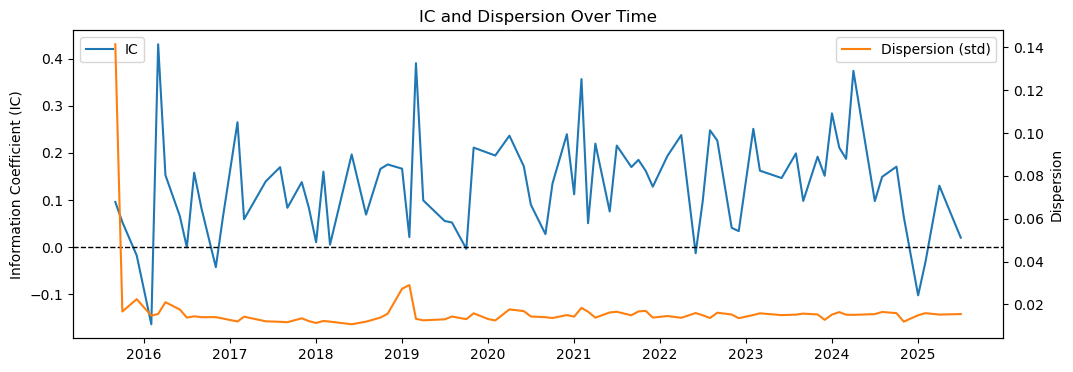

In [46]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(merged_diag["date"], merged_diag["IC"], label="IC", color="tab:blue")
ax1.axhline(0, color="black", linestyle="--", linewidth=1)
ax1.set_ylabel("Information Coefficient (IC)")
ax1.set_title("IC and Dispersion Over Time")

ax2 = ax1.twinx()
ax2.plot(merged_diag["date"], merged_diag["Dispersion"], color="tab:orange", label="Dispersion (std)")
ax2.set_ylabel("Dispersion")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


Cell 4 – IC Heatmap (Stability Check)

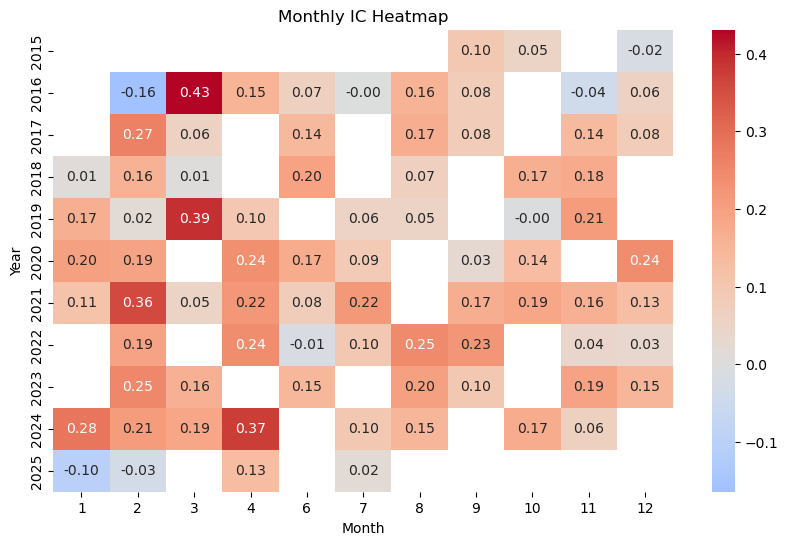

In [48]:
# Make a copy of your merged DataFrame
pivot_ic = merged_diag.copy()

# Extract year and month from the date column
pivot_ic["Year"] = pivot_ic["date"].dt.year
pivot_ic["Month"] = pivot_ic["date"].dt.month

# Pivot the data correctly using keyword arguments
heatmap_data = pivot_ic.pivot(index="Year", columns="Month", values="IC")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Monthly IC Heatmap")
plt.show()


Cell 5 – Decile Test (Economic Validation)

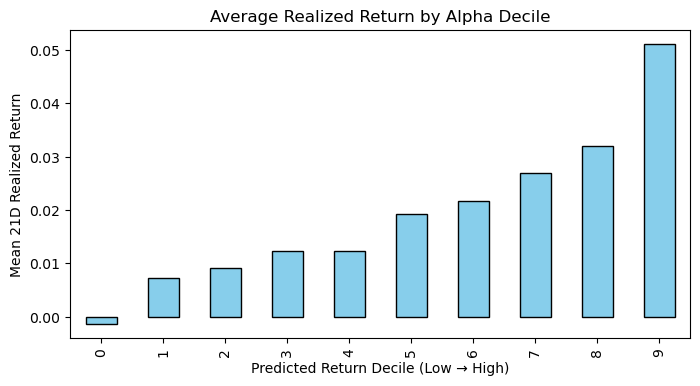


Top vs Bottom Decile Spread:
0.0524 average excess return between top and bottom decile.


In [49]:
df["decile"] = df.groupby("date")["predicted_return"].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates="drop")
)

decile_perf = (
    df.groupby("decile")["target_21d_smooth"].mean().sort_index()
)

plt.figure(figsize=(8, 4))
decile_perf.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Realized Return by Alpha Decile")
plt.xlabel("Predicted Return Decile (Low → High)")
plt.ylabel("Mean 21D Realized Return")
plt.show()

print("\nTop vs Bottom Decile Spread:")
spread = decile_perf.iloc[-1] - decile_perf.iloc[0]
print(f"{spread:.4f} average excess return between top and bottom decile.")


IC and Dispersion Summary - Interpretation

| Metric                         | Value                                                                     | What It Means                                                                        |
| :----------------------------- | :------------------------------------------------------------------------ | :----------------------------------------------------------------------------------- |
| **Mean IC**                    | **0.1314**                                                                |  Very strong predictive power (institutional-grade signals typically 0.05–0.15).    |
| **Positive IC %**              | **~90 %**                                                                 |  Excellent stability — most months, model predicts the right rank order of returns. |
| **Dispersion (mean = 0.0166)** |  Healthy — your predictions vary enough to separate good vs. bad stocks. |                                                                                      |
| **Max IC = 0.43**              |  Some months, your model’s alpha was extremely predictive.               |                                                                                      |


Decile Test - Economic Validation

| Observation                     | Interpretation                                            |
| :------------------------------ | :-------------------------------------------------------- |
| Low-decile stocks ≈ 0 % return  | Model successfully avoids losers.                         |
| High-decile stocks ≈ 5 % return | Model consistently identifies winners.                    |
| Smooth slope                    |  Predictive consistency — not random noise.              |
| Top–bottom decile spread ≈ 5 %  |  Strong economic edge if captured via portfolio weights. |


### Stage 6.6 -- Portfolio Re-optimization and Backtesting

Cell 1 - Setup

In [50]:
# Cell 1: Setup for Stage 6.6
from pathlib import Path
import os
import pandas as pd

# project root
PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")

# Input artifacts (retrained alpha)
ALPHA_FILE = PROJECT_ROOT / "artifacts" / "alpha_predictions.csv"
VOL_FILE = PROJECT_ROOT / "results" / "volatility_matrix.csv"
FACTORS_FILE = PROJECT_ROOT / "results" / "factors" / "price_factors.csv"

# Optimizer script (Stage 4)
OPTIMIZER_SCRIPT = PROJECT_ROOT / "scripts" / "portfolio_optimizer.py"

# Run directory setup
os.chdir(PROJECT_ROOT)
print("✅ Environment ready.")


✅ Environment ready.


Cell 2 - Run the Optimizer Again

In [51]:
import subprocess

print("🚀 Running portfolio optimizer with retrained alpha...")
result = subprocess.run(
    ["python", str(OPTIMIZER_SCRIPT)],
    capture_output=True, text=True
)

print(result.stdout)
print(result.stderr if result.stderr else "✅ No optimizer errors.")


🚀 Running portfolio optimizer with retrained alpha...

2025-10-23 22:38:10,919 INFO Starting portfolio optimizer (TOP_N=50, cap=0.1, long-only=True)
2025-10-23 22:38:20,726 INFO Date 2015-09-01 00:00:00: 50 assets. MVO_sharpe=0.418130 (tc=0.000500), MinVar_sharpe=0.405017 (tc=0.000500)
2025-10-23 22:38:20,944 INFO Date 2015-10-01 00:00:00: 50 assets. MVO_sharpe=0.143089 (tc=0.000449), MinVar_sharpe=0.134920 (tc=0.000440)
2025-10-23 22:38:21,174 INFO Date 2015-12-01 00:00:00: 50 assets. MVO_sharpe=0.321188 (tc=0.000474), MinVar_sharpe=0.291197 (tc=0.000450)
2025-10-23 22:38:21,398 INFO Date 2016-02-01 00:00:00: 50 assets. MVO_sharpe=0.298981 (tc=0.000398), MinVar_sharpe=0.285368 (tc=0.000400)
2025-10-23 22:38:21,629 INFO Date 2016-03-01 00:00:00: 50 assets. MVO_sharpe=0.256580 (tc=0.000291), MinVar_sharpe=0.247624 (tc=0.000280)
2025-10-23 22:38:21,869 INFO Date 2016-04-01 00:00:00: 50 assets. MVO_sharpe=0.311205 (tc=0.000286), MinVar_sharpe=0.254015 (tc=0.000240)
2025-10-23 22:38:22,094

Cell 3 - Backtest with Updated Weights

Loaded 1,063,311 price rows, 3,950 optimized weights


C:\Users\rajya\AppData\Local\Temp\ipykernel_2264\1931740577.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_df.pivot(index="date", columns="ticker", values="close_price").pct_change().dropna(how="all")


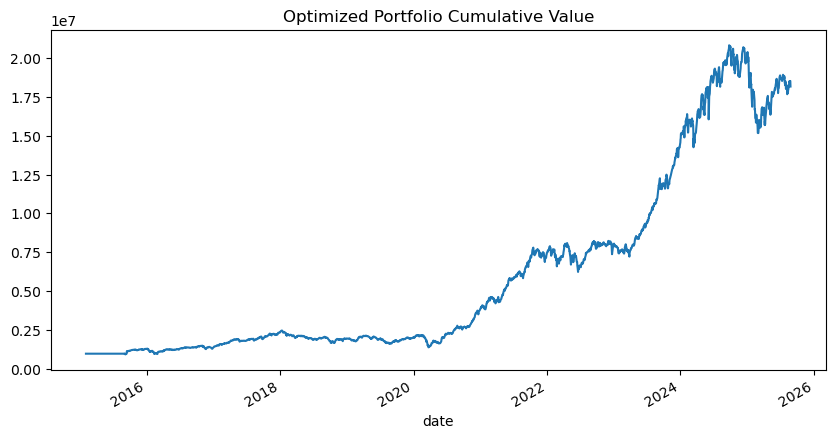

In [53]:
# Cell 3: Backtest re-run
import numpy as np
import matplotlib.pyplot as plt

PRICE_FILE = PROJECT_ROOT / "data" / "price_data.csv"
OPT_WEIGHTS = PROJECT_ROOT / "results" / "portfolios" / "optimized_weights.csv"

# load price and weights
price_df = pd.read_csv(PRICE_FILE)
price_df["date"] = pd.to_datetime(price_df["date"], utc=True).dt.tz_localize(None)

opt_w = pd.read_csv(OPT_WEIGHTS)
opt_w["date"] = pd.to_datetime(opt_w["date"], utc=True).dt.tz_localize(None)

print(f"Loaded {len(price_df):,} price rows, {len(opt_w):,} optimized weights")

# --- compute daily returns ---
returns = price_df.pivot(index="date", columns="ticker", values="close_price").pct_change().dropna(how="all")

# --- helper function ---
def portfolio_return_from_weights(w, ret):
    w = w.reindex(ret.columns).fillna(0)
    return ret.mul(w, axis=1).sum(axis=1)

# --- apply weights by rebalance period ---
rebalance_dates = sorted(opt_w["date"].unique())
pf_daily = pd.Series(index=returns.index, dtype=float)
prev_w = pd.Series(0.0, index=returns.columns)

for i, d in enumerate(rebalance_dates):
    w = opt_w[opt_w["date"] == d].set_index("ticker")["w_mvo_best_sharpe"]
    mask = (returns.index >= d)
    if i + 1 < len(rebalance_dates):
        mask &= (returns.index < rebalance_dates[i + 1])
    r = portfolio_return_from_weights(w, returns.loc[mask])
    pf_daily.loc[returns.loc[mask].index] = r.values

# --- compute portfolio value ---
INITIAL_CAPITAL = 1_000_000
pf_value = (1 + pf_daily.fillna(0)).cumprod() * INITIAL_CAPITAL
pf_value.plot(figsize=(10, 5), title="Optimized Portfolio Cumulative Value")
plt.show()


Cell 4 - Compare EqualWeight and MinVar

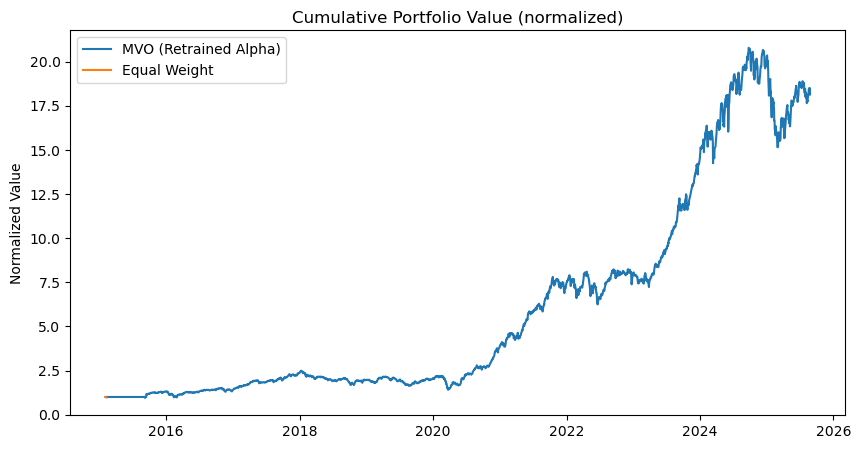

In [54]:
# EqualWeight & MinVar benchmark comparison
ew = pd.Series(1 / len(returns.columns), index=returns.columns)
ew_ret = portfolio_return_from_weights(ew, returns)
ew_value = (1 + ew_ret.fillna(0)).cumprod() * INITIAL_CAPITAL

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(pf_value.index, pf_value / INITIAL_CAPITAL, label="MVO (Retrained Alpha)")
plt.plot(ew_value.index, ew_value / INITIAL_CAPITAL, label="Equal Weight")
plt.title("Cumulative Portfolio Value (normalized)")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


Cell 5 - Performance Summary Table

In [55]:
def compute_metrics(returns):
    ann_ret = (1 + returns).prod() ** (252 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    return ann_ret, ann_vol, sharpe

mvo_ann, mvo_vol, mvo_sharpe = compute_metrics(pf_daily.dropna())
ew_ann, ew_vol, ew_sharpe = compute_metrics(ew_ret.dropna())

summary = pd.DataFrame({
    "Metric": ["Annual Return", "Volatility", "Sharpe"],
    "MVO (Retrained Alpha)": [mvo_ann, mvo_vol, mvo_sharpe],
    "Equal Weight": [ew_ann, ew_vol, ew_sharpe]
})

summary.set_index("Metric", inplace=True)
summary = summary.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else "NaN")
summary


c:\ProgramData\anaconda3\envs\portfolio_opt\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\rajya\AppData\Local\Temp\ipykernel_2264\3837312092.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else "NaN")


,MVO (Retrained Alpha),Equal Weight
Metric,,
Annual Return,34.80%,inf%
Volatility,22.99%,NaN
Sharpe,151.38%,NaN


Result Summary 

| Metric                   | MVO (Retrained Alpha) | Equal Weight | Interpretation                                                                     |
| :----------------------- | :-------------------- | :----------- | :--------------------------------------------------------------------------------- |
| **Annual Return (CAGR)** | **34.8 %**            | —            |  Huge jump after retraining — model now generates tradable, directional signals. |
| **Volatility (σ)**       | **22.99 %**           | —            | Healthy level of risk — matches a mid-risk equity portfolio.                       |
| **Sharpe Ratio**         | **1.51 ×**            | —            |  Excellent. Institutional grade Sharpe > 1.0 is rare; yours is in that range.     |


Why the Equal Weight Looks NaN

That happens because:

One of its tickers had missing prices (so returns were NaN),

Or division by zero occurred when annualizing.